In [553]:
library("tidyr")
library("dplyr")
library("nhs.predict")
library("ggplot2")
library("ggsci")

# input data

In [554]:
age.start  <- 50
screen     <- 0     # Clinically detected = 0, screen detected = 1 (webのsymptoms -> 0)
size       <- 50    # Tumour size mm
grade      <- 3     # Tumour grade
nodes      <- 5     # Number positive nodes
er         <- 1     # ER+ = 1, ER- = 0
her2       <- 1     # HER2+ = 1, HER2- = 0, missing = 9
ki67       <- 1     # KI67+ = 1, KI67- = 0, missing = 9
generation <- 3     # Chemo generation 0, 2 or 3 only
horm       <- 1     # Hormone therapy Yes = 1, no = 0
traz       <- 1     # Trastuzumab therapy Yes = 1, no = 0
bis        <- 1     # Bisphosphonate therapy Yes = 1, no = 0
radio      <- 0     # Radiotherapy Yes = 1, no = 0

r.enabled  <- 0     # Radiotherapy enabled = 1, disabled = 0

# screenとgradeの調整

In [555]:
##----------------------------------------------------------------
##[WINTON FIX] Fix inputs
screen    <- ifelse(screen == 2, 0.204, screen)
grade     <- ifelse(grade == 9, 2.13, grade)

# time,ageの設定

In [556]:
## ------------------------------------------------------------------------
time      <- c(1:15)
age       <- age.start - 1 + time
##[WINTON FIX] - Input changed to include grade = 9
grade.val <- ifelse(er==1, grade, ifelse(grade==2 || grade == 3, 1, 0)) # Grade variable for ER neg

cat("time:", time, "\n")
cat("age:",age, "\n")
cat("grade.val", grade.val)

time: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 
age: 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 
grade.val 3

# baselineの係数と変数

In [557]:
## ------------------------------------------------------------------------
age.mfp.1   <- ifelse(er==1, (age.start/10)^-2-.0287449295, age.start-56.3254902)
age.beta.1  <- ifelse(er==1, 34.53642, 0.0089827)
age.mfp.2   <- ifelse(er==1, (age.start/10)^-2*log(age.start/10)-.0510121013, 0)
age.beta.2  <- ifelse(er==1, -34.20342, 0)
size.mfp    <- ifelse(er==1, log(size/100)+1.545233938, (size/100)^.5-.5090456276)
size.beta   <- ifelse(er==1, 0.7530729, 2.093446)
nodes.mfp   <- ifelse(er==1, log((nodes+1)/10)+1.387566896, log((nodes+1)/10)+1.086916249)
nodes.beta  <- ifelse(er==1, 0.7060723, .6260541)
grade.beta  <- ifelse(er==1, 0.746655, 1.129091)
screen.beta <- ifelse(er==1, -0.22763366, 0)
her2.beta   <- ifelse(her2==1, 0.2413,
                      ifelse(her2==0, -0.0762,0 ))
ki67.beta   <- ifelse(ki67==1 & er==1, 0.14904,
                      ifelse(ki67==0 & er==1, -0.11333,0 )) #[WINTON FIX] - Missing 3 at the end

# baselineと調整項

$$ 
\begin{align}
    Other \ mortality \ : \ prognostic \ index \ (mi)  &= 0.0698252 \times \big((\frac{age}{10}\big)^2 - 34.23391957\big) + Radiotherapy \ による調整項\\\\
    Breast \ cancer \  mortality \ : \ prognostic \ index \ (pi)  &= b'_cx_R
\end{align}
$$

In [558]:
## ----baseline_adjust-----------------------------------------------------
r.prop   <- 0.69 # Proportion of population receiving radiotherapy
r.breast <- 0.82 # Relative hazard breast specifi mortality from Darby et al
r.other  <- 1.07 # Relative hazard other mortality from Darby et al

if (r.enabled == 1) {
  r.base.br  <- log(1/((1-r.prop) + r.prop*r.breast))
  r.base.oth <- log(1/((1-r.prop) + r.prop*r.other))
} else {
  r.base.br   <- 0
  r.base.oth  <- 0
}

In [559]:
## ------------------------------------------------------------------------
# Other mortality prognostic index (mi)
mi <- 0.0698252*((age.start/10)^2-34.23391957) + r.base.oth
mi

[1] -0.6447603

In [560]:
# Breast cancer mortality prognostic index (pi)
pi <- age.beta.1*age.mfp.1 + age.beta.2*age.mfp.2 + size.beta*size.mfp +
  nodes.beta*nodes.mfp + grade.beta*grade.val + screen.beta*screen +
  her2.beta + ki67.beta + r.base.br
pi

[1] 3.822598

In [561]:
c     <- ifelse(generation == 0, 0, ifelse(generation == 2, -.248, -.446))
h     <- ifelse(horm==1 & er==1, -0.3857, 0)
h10  <- c(rep(h, 10), rep(-.26+h, 5)) #including both ATLAS and aTTom trials
t     <- ifelse(her2==1 & traz==1, -.3567, 0)
b     <- ifelse(bis==1, -0.198, 0) # Only applicable to menopausal women.

if(r.enabled == 1) {
  r.br  <- ifelse(radio==1, log(r.breast), 0)
  r.oth <- ifelse(radio==1, log(r.other), 0)
} else {
  r.br = 0
  r.oth = 0
}

rx <- tibble(s = rep(0, 15),
             c = c,
             h = h,
             t = t,
             b = b,
             hc = h + c,
             ht = h + t,
             hb = h + b,
             ct = c + t, # It is unlikely that hromone therapy would not be offered
             cb = c + b, # in a woman with ER positive disease
             tb = t + b,
             hct = h + c + t,
             hcb = h + c + b,
             htb = h + t + b,
             ctb = c + t + b,
             hctb = h + c + t + b,
             h10 = h10,
             h10c = h10 + c,
             h10t = h10 + t,
             h10b = h10 + b,
             h10ct = h10 + c + t,
             h10cb = h10 + c + b,
             h10tb = h10 + t + b,
             h10ctb = h10 + c + t + b,
             hr = h + r.br,
             rc = r.br + c,
             rt = r.br + t,
             rb = r.br + b,
             hrc = h + r.br + c,
             hrt = h + r.br + t,
             hrb = h + r.br + b,
             rct = r.br + c + t,
             rcb = r.br + c + b,
             rtb = r.br + t + b,
             hrct = h + r.br + c + t,
             hrcb = h + r.br + t + b,
             hrtb = h + r.br + t + b,
             rctb = r.br + c + t + b,
             hrctb = h + r.br + c + t + b,
             h10r = h10 + r.br,
             h10rc = h10 + r.br + c,
             h10rt = h10 + r.br + t,
             h10rb = h10 + r.br + b,
             h10rct = h10 + r.br + c + t,
             h10rcb = h10 + r.br + t + b,
             h10rtb = h10 + r.br + t + b,
             h10rctb = h10 + r.br + c + t + b)
rx

s,c,h,t,b,hc,ht,hb,ct,cb,⋯,rctb,hrctb,h10r,h10rc,h10rt,h10rb,h10rct,h10rcb,h10rtb,h10rctb
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,-0.446,-0.3857,-0.3567,-0.198,-0.8317,-0.7424,-0.5837,-0.8027,-0.644,⋯,-1.0007,-1.3864,-0.3857,-0.8317,-0.7424,-0.5837,-1.1884,-0.9404,-0.9404,-1.3864
0,-0.446,-0.3857,-0.3567,-0.198,-0.8317,-0.7424,-0.5837,-0.8027,-0.644,⋯,-1.0007,-1.3864,-0.3857,-0.8317,-0.7424,-0.5837,-1.1884,-0.9404,-0.9404,-1.3864
0,-0.446,-0.3857,-0.3567,-0.198,-0.8317,-0.7424,-0.5837,-0.8027,-0.644,⋯,-1.0007,-1.3864,-0.3857,-0.8317,-0.7424,-0.5837,-1.1884,-0.9404,-0.9404,-1.3864
0,-0.446,-0.3857,-0.3567,-0.198,-0.8317,-0.7424,-0.5837,-0.8027,-0.644,⋯,-1.0007,-1.3864,-0.3857,-0.8317,-0.7424,-0.5837,-1.1884,-0.9404,-0.9404,-1.3864
0,-0.446,-0.3857,-0.3567,-0.198,-0.8317,-0.7424,-0.5837,-0.8027,-0.644,⋯,-1.0007,-1.3864,-0.3857,-0.8317,-0.7424,-0.5837,-1.1884,-0.9404,-0.9404,-1.3864
0,-0.446,-0.3857,-0.3567,-0.198,-0.8317,-0.7424,-0.5837,-0.8027,-0.644,⋯,-1.0007,-1.3864,-0.3857,-0.8317,-0.7424,-0.5837,-1.1884,-0.9404,-0.9404,-1.3864
0,-0.446,-0.3857,-0.3567,-0.198,-0.8317,-0.7424,-0.5837,-0.8027,-0.644,⋯,-1.0007,-1.3864,-0.3857,-0.8317,-0.7424,-0.5837,-1.1884,-0.9404,-0.9404,-1.3864
0,-0.446,-0.3857,-0.3567,-0.198,-0.8317,-0.7424,-0.5837,-0.8027,-0.644,⋯,-1.0007,-1.3864,-0.3857,-0.8317,-0.7424,-0.5837,-1.1884,-0.9404,-0.9404,-1.3864
0,-0.446,-0.3857,-0.3567,-0.198,-0.8317,-0.7424,-0.5837,-0.8027,-0.644,⋯,-1.0007,-1.3864,-0.3857,-0.8317,-0.7424,-0.5837,-1.1884,-0.9404,-0.9404,-1.3864


In [562]:
rx <- rx + pi

cols <- ncol(rx)
rx

s,c,h,t,b,hc,ht,hb,ct,cb,⋯,rctb,hrctb,h10r,h10rc,h10rt,h10rb,h10rct,h10rcb,h10rtb,h10rctb
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
3.822598,3.376598,3.436898,3.465898,3.624598,2.990898,3.080198,3.238898,3.019898,3.178598,⋯,2.821898,2.436198,3.436898,2.990898,3.080198,3.238898,2.634198,2.882198,2.882198,2.436198
3.822598,3.376598,3.436898,3.465898,3.624598,2.990898,3.080198,3.238898,3.019898,3.178598,⋯,2.821898,2.436198,3.436898,2.990898,3.080198,3.238898,2.634198,2.882198,2.882198,2.436198
3.822598,3.376598,3.436898,3.465898,3.624598,2.990898,3.080198,3.238898,3.019898,3.178598,⋯,2.821898,2.436198,3.436898,2.990898,3.080198,3.238898,2.634198,2.882198,2.882198,2.436198
3.822598,3.376598,3.436898,3.465898,3.624598,2.990898,3.080198,3.238898,3.019898,3.178598,⋯,2.821898,2.436198,3.436898,2.990898,3.080198,3.238898,2.634198,2.882198,2.882198,2.436198
3.822598,3.376598,3.436898,3.465898,3.624598,2.990898,3.080198,3.238898,3.019898,3.178598,⋯,2.821898,2.436198,3.436898,2.990898,3.080198,3.238898,2.634198,2.882198,2.882198,2.436198
3.822598,3.376598,3.436898,3.465898,3.624598,2.990898,3.080198,3.238898,3.019898,3.178598,⋯,2.821898,2.436198,3.436898,2.990898,3.080198,3.238898,2.634198,2.882198,2.882198,2.436198
3.822598,3.376598,3.436898,3.465898,3.624598,2.990898,3.080198,3.238898,3.019898,3.178598,⋯,2.821898,2.436198,3.436898,2.990898,3.080198,3.238898,2.634198,2.882198,2.882198,2.436198
3.822598,3.376598,3.436898,3.465898,3.624598,2.990898,3.080198,3.238898,3.019898,3.178598,⋯,2.821898,2.436198,3.436898,2.990898,3.080198,3.238898,2.634198,2.882198,2.882198,2.436198
3.822598,3.376598,3.436898,3.465898,3.624598,2.990898,3.080198,3.238898,3.019898,3.178598,⋯,2.821898,2.436198,3.436898,2.990898,3.080198,3.238898,2.634198,2.882198,2.882198,2.436198


# Other mortalityの累積死亡率

In [563]:
## ------------------------------------------------------------------------
# Generate cumulative baseline other mortality
base.m.cum.oth <- exp(-6.052919 + (1.079863*log(time)) + (.3255321*time^.5))

# Generate cumulative survival non-breast mortality
s.cum.oth <- exp(-exp(mi+r.oth)*base.m.cum.oth)

# Convert cumulative mortality rate into cumulative risk
m.cum.oth <- 1- s.cum.oth

# Annual other mortality rate 年単位の死亡率
m.oth <- m.cum.oth
for (i in 2:15) {
  m.oth[i] <- m.cum.oth[i] - m.cum.oth[i-1]
}
cat("累積 : ", m.cum.oth,  "\n")
cat("年単位 : ", m.oth, "\n")

累積 :  0.001707028 0.004124258 0.007076054 0.01051568 0.0144213 0.01878114 0.02358846 0.02883921 0.0345309 0.04066189 0.0472309 0.05423677 0.06167818 0.06955356 0.07786089 
年単位 :  0.001707028 0.00241723 0.002951796 0.003439623 0.003905619 0.004359848 0.004807314 0.00525075 0.005691695 0.006130986 0.006569013 0.007005866 0.007441416 0.007875375 0.008307331 


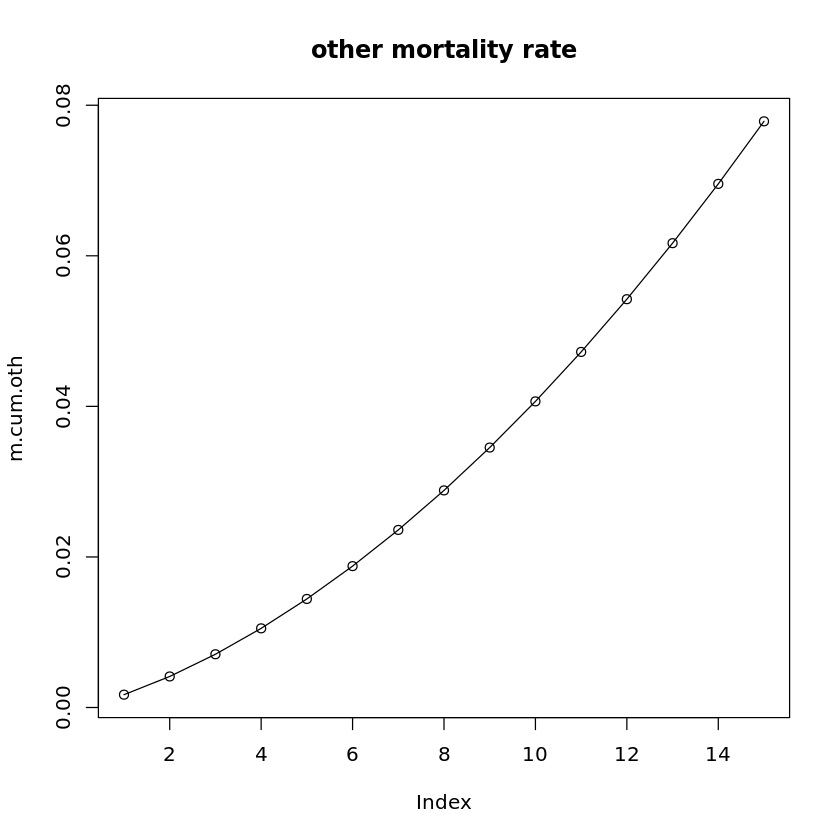

In [564]:
plot(m.cum.oth, type="o", main="other mortality rate")

# baseline breast mortality 累積死亡率

$$ 
\begin{align}
    ER+ : \ H_c(t)  &= exp\big(0.7424402 - \frac{7.527762}{\sqrt{t}} - 1.812513 \times \frac{log(t)}{\sqrt{t}}\big) \\\\
    ER- : \ H_c(t)  &= exp\big(-1.156036 + \frac{0.4707332}{t^2} - \frac{3.51355}{t}\big)
\end{align}
$$

In [601]:
## ------------------------------------------------------------------------
# Generate cumulative baseline breast mortality
if (er==1) {
  base.m.cum.br <- exp(0.7424402 - 7.527762/time^.5 - 1.812513*log(time)/time^.5)
} else { base.m.cum.br <- exp(-1.156036 + 0.4707332/time^2 - 3.51355/time)
}

# Generate annual baseline breast mortality
base.m.br <- base.m.cum.br
for (i in 2:15) {
  base.m.br[i] <- base.m.cum.br[i] - base.m.cum.br[i-1] }

In [602]:
# Generate the annual breast cancer specific mortality rate
m.br <- base.m.br*exp(rx)

# Calculate the cumulative breast cancer mortality rate
m.cum.br <- apply(m.br, 2, cumsum)

# Calculate the cumulative breast cancer survival
s.cum.br <- exp(- m.cum.br)
m.cum.br <- 1- s.cum.br

m.br <- m.cum.br
for (j in 1:cols) {
  for (i in 2:15) {
    m.br[i,j] <- m.cum.br[i,j] - m.cum.br[i-1,j]
  }
}

# Cumulative all cause mortality conditional on surviving breast and all cause mortality
m.cum.all <- 1 - s.cum.oth*s.cum.br
s.cum.all <- 100-100*m.cum.all

# Annual all cause mortality
m.all <- m.cum.all
for (j in 1:cols) {
  for (i in 2:15) {
    m.all[i,j] <- m.cum.all[i,j] - m.cum.all[i-1,j]
  }
}

In [607]:
length(base.m.br)
dim(base.m.br*exp(rx))
head(rx)

[1] 15

[1] 15 47

,s,c,h,t,b,hc,ht,hb,ct,cb,⋯,rctb,hrctb,h10r,h10rc,h10rt,h10rb,h10rct,h10rcb,h10rtb,h10rctb
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,3.822598,3.376598,3.436898,3.465898,3.624598,2.990898,3.080198,3.238898,3.019898,3.178598,⋯,2.821898,2.436198,3.436898,2.990898,3.080198,3.238898,2.634198,2.882198,2.882198,2.436198
2,3.822598,3.376598,3.436898,3.465898,3.624598,2.990898,3.080198,3.238898,3.019898,3.178598,⋯,2.821898,2.436198,3.436898,2.990898,3.080198,3.238898,2.634198,2.882198,2.882198,2.436198
3,3.822598,3.376598,3.436898,3.465898,3.624598,2.990898,3.080198,3.238898,3.019898,3.178598,⋯,2.821898,2.436198,3.436898,2.990898,3.080198,3.238898,2.634198,2.882198,2.882198,2.436198
4,3.822598,3.376598,3.436898,3.465898,3.624598,2.990898,3.080198,3.238898,3.019898,3.178598,⋯,2.821898,2.436198,3.436898,2.990898,3.080198,3.238898,2.634198,2.882198,2.882198,2.436198
5,3.822598,3.376598,3.436898,3.465898,3.624598,2.990898,3.080198,3.238898,3.019898,3.178598,⋯,2.821898,2.436198,3.436898,2.990898,3.080198,3.238898,2.634198,2.882198,2.882198,2.436198
6,3.822598,3.376598,3.436898,3.465898,3.624598,2.990898,3.080198,3.238898,3.019898,3.178598,⋯,2.821898,2.436198,3.436898,2.990898,3.080198,3.238898,2.634198,2.882198,2.882198,2.436198


# Dataframe化して確認

In [582]:
other <- data.frame(s.cum.oth * 100)
colnames(other) <- c("other")

In [583]:
results_table <- data.frame(s.cum.all)
select_col <- c('s','h','c','t','b','h10','h10t','h10c','ctb')
results_selected <- results_table[,select_col]
results_selected <- cbind(other, results_selected)
num_col <- ncol(results_selected)

In [584]:
melted <- melt(results_selected)
year <- data.frame(rep(c(1:15),num_col))
melted <- cbind(year, melted)

colnames(melted) <- c("year", "type", "survival_rate")

No id variables; using all as measure variables



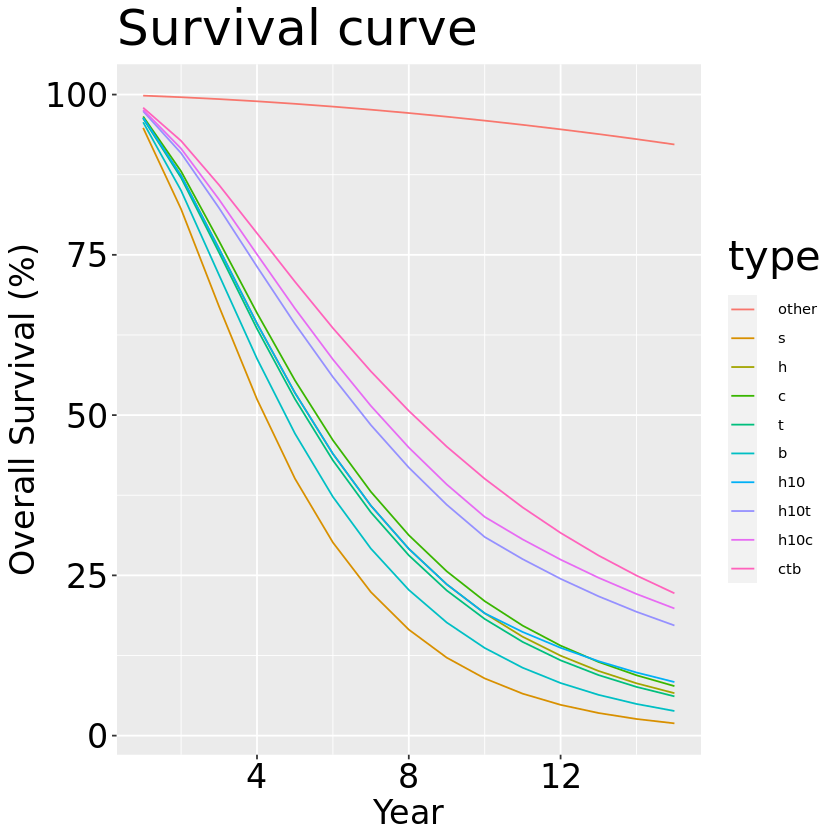

In [585]:
g <- ggplot(melted, aes(x = year, y = survival_rate, group = type, colour = type)) + geom_line()


g <- g + theme(axis.title.x = element_text(size = 20, family = "Arial"),
               axis.title.y = element_text(size = 20, family = "Arial"),
               axis.text.x = element_text(size = 20, colour = 1, family = "Arial"),
               axis.text.y = element_text(size = 20, colour = 1, family = "Arial"),
               title=element_text(size = 25, family = "Arial")
              )
g <- g + labs(x = "Year", y = "Overall Survival (%)", title="Survival curve")
plot(g)

In [586]:
results_selected[c(5,10,15),select_col]

,s,h,c,t,b,h10,h10t,h10c,ctb
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
5,40.095797,53.468550,55.416661,52.515009,47.126049,53.468550,64.23636,66.62896,70.81103
10,8.927731,19.088034,20.979474,18.202388,13.676696,19.088034,30.98394,34.12464,40.07455
15,1.917582,6.622935,7.726453,6.129093,3.845028,8.363119,17.18363,19.83585,22.20448


In [571]:
## ------------------------------------------------------------------------
# Proportion of all cause mortality that is breast cancer
prop.br      <- m.br/(m.br + m.oth)
pred.m.br    <- prop.br*m.all
pred.cum.br  <- apply(pred.m.br, 2, cumsum)
pred.m.oth   <- m.all - pred.m.br
pred.cum.oth <- apply(pred.m.oth, 2, cumsum)
pred.cum.all <- pred.cum.br + pred.cum.oth

In [572]:
## ------------------------------------------------------------------------
# rx benefits
# version implemented on web has benefit as difference in breast specific mortality
benefits2.2 <- 100*(pred.cum.all[,1] - pred.cum.all)

In [573]:
## -----------------------------------------------------------------------
#
start <- 6
m.oth <- m.oth[start:15]
m.br <- m.br[start:15,]
m.all <- m.all[start:15,]

# Proportion of all cause mortality that is breast cancer
prop.br      <- m.br/(m.br + m.oth)
pred.m.br    <- prop.br*m.all
pred.cum.br  <- apply(pred.m.br, 2, cumsum)
pred.m.oth   <- m.all - pred.m.br
pred.cum.oth <- apply(pred.m.oth, 2, cumsum)
pred.cum.all <- pred.cum.br + pred.cum.oth

In [574]:
## ------------------------------------------------------------------------
# rx benefits
# version implemented on web has benefit as difference in breast specific mortality
benefits2.2.delay <- 100*(pred.cum.all[,1] - pred.cum.all)

In [588]:
a <-data(example_data)

In [592]:
colnames(example_data)

[1] "pID"         "age"         "detection"   "t.size"      "t.grade"    
 [6] "nodes"       "er.status"   "her2.status" "ki67.status" "chemo.gen"  
[11] "horm.t"      "trastuzumab" "bis.t"

In [594]:
library("readr")
example_data %>% write_csv("./input_data.csv")


for data, event in zip(input_csv, events):
    p1  = I(data, event)
    ps.append(p1)
------------------------------
                       
                       
                       
    p1.predict()
    p1.ER 
    p1.treatoptions -> "_c__", "h0c1t0b0"
    ps.append()